In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM

from itertools import cycle
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')

In [3]:
import warnings
warnings.filterwarnings("ignore")
from Historic_Crypto import HistoricalData

#btc_historicals = HistoricalData("BTC-USD", 300, "2015-12-29-00-00", "2021-10-30-00-00").retrieve_data()
#btc_historicals.to_csv("/content/drive/MyDrive/ColabNotebooks/btc_5min.csv")


In [2]:
pip install Historic-Crypto

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
root_path = "/content/drive/MyDrive/ColabNotebooks/btc_ohlc_Oct_2015_to_Oct_2021.csv"

btc_historicals = pd.read_csv(root_path)
#btc_input_df2 = pd.read_csv(btc_historicals)

In [6]:
btc_historicals.tail()

,time,low,high,open,close,volume
3113271,2015-10-27 00:04:00,287.07,287.07,287.07,287.07,0.08610
3113272,2015-10-27 00:03:00,287.08,287.09,287.08,287.09,0.55440
3113273,2015-10-27 00:02:00,286.89,287.10,287.10,286.89,72.40320
3113274,2015-10-27 00:01:00,287.09,287.09,287.09,287.09,0.82276
3113275,2015-10-27 00:00:00,287.10,287.10,287.10,287.10,0.53620


In [7]:
btc_historicals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   time    object 
 1   low     float64
 2   high    float64
 3   open    float64
 4   close   float64
 5   volume  float64
dtypes: float64(5), object(1)
memory usage: 142.5+ MB


In [8]:
btc_historicals['time'] = pd.to_datetime(btc_historicals['time'])

In [9]:
btc_historicals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3113276 entries, 0 to 3113275
Data columns (total 6 columns):
 #   Column  Dtype         
---  ------  -----         
 0   time    datetime64[ns]
 1   low     float64       
 2   high    float64       
 3   open    float64       
 4   close   float64       
 5   volume  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 142.5 MB


In [10]:
print('Null Values:',btc_historicals.isnull().values.sum())
print('If any NA values:', btc_historicals.isnull().values.any())

Null Values: 0
If any NA values: False


In [ ]:
#btc_historicals_datetype = btc_historicals

In [14]:
btc_historicals['date'] = pd.to_datetime(btc_historicals['time'],unit='s').dt.date

display(btc_historicals.head())

group = btc_historicals.groupby('date')

btc_closing_price_groupby_date = group['close'].mean()

,time,low,high,open,close,volume,date
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079,2021-10-30
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357,2021-10-30
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848,2021-10-30
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070,2021-10-30
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128,2021-10-30


In [ ]:
#btc_historicals_datetype = btc_historicals_datetype['close']

In [ ]:
#btc_historicals_datetype = btc_historicals_datetype.drop("mean", axis = 1)

In [ ]:
#btc_historicals_datetype['mean'] = btc_historicals_datetype.mean(axis=1)

In [16]:
len(btc_closing_price_groupby_date)

2196

In [17]:
prediction_days = 60

# Set Train data to be uplo ( Total data length - prediction_days )
df_train= btc_closing_price_groupby_date[:len(btc_closing_price_groupby_date)-prediction_days].values.reshape(-1,1)


# Set Test data to be the last prediction_days (or 60 days in this case)
df_test= btc_closing_price_groupby_date[len(btc_closing_price_groupby_date)-prediction_days:].values.reshape(-1,1)

In [18]:
df_train.shape

(2136, 1)

In [19]:
df_test.shape

(60, 1)

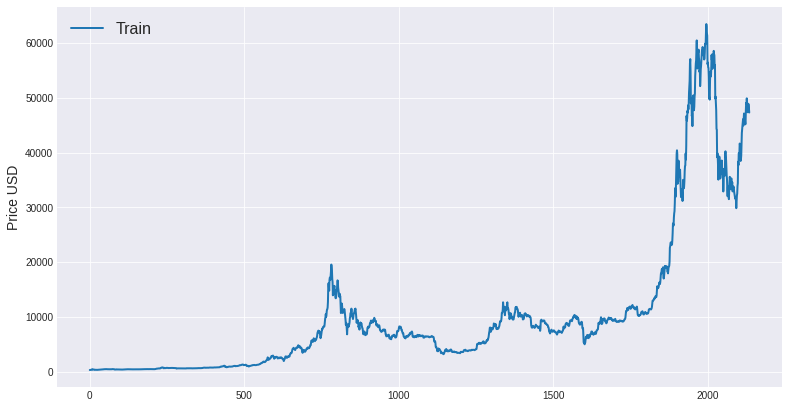

In [20]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [21]:
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [22]:
scaled_test

array([[0.25321869],
       [0.33878686],
       [0.34931688],
       [0.35652903],
       [0.36882444],
       [0.43055223],
       [0.35190522],
       [0.19320919],
       [0.19855227],
       [0.17701621],
       [0.15325192],
       [0.16480254],
       [0.12865804],
       [0.18263966],
       [0.24906473],
       [0.26251689],
       [0.24876467],
       [0.27712791],
       [0.25529524],
       [0.12094002],
       [0.02665216],
       [0.03215063],
       [0.09826223],
       [0.05653365],
       [0.03321796],
       [0.04218533],
       [0.07336325],
       [0.004752  ],
       [0.        ],
       [0.06214595],
       [0.18340176],
       [0.26015549],
       [0.26810129],
       [0.27380695],
       [0.35673344],
       [0.47981766],
       [0.54177128],
       [0.5459711 ],
       [0.55826613],
       [0.5765067 ],
       [0.64334068],
       [0.63971782],
       [0.61481564],
       [0.68357564],
       [0.78050369],
       [0.8405857 ],
       [0.82202495],
       [0.862

In [23]:
def dataset_generator_lstm(dataset, look_back=5):
    # A “lookback period” defines the window-size of how many
    # previous timesteps are used in order to predict
    # the subsequent timestep. 
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):
        window_size_x = dataset[i:(i + look_back), 0]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)

testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testX: ", testX.shape)
print("testY", testY.shape)

trainX:  (2131, 5)
trainY:  (2131,)
testX:  (55, 5)
testY (55,)


In [24]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (2131, 5, 1)
Shape of testX:  (55, 5, 1)


In [ ]:
trainX

array([[[0.00289836],
        [0.00290087],
        [0.00290087],
        ...,
        [0.0029222 ],
        [0.00289083],
        [0.00287912]],

       [[0.00290087],
        [0.00290087],
        [0.00290087],
        ...,
        [0.00289083],
        [0.00287912],
        [0.00287577]],

       [[0.00290087],
        [0.00290087],
        [0.0029222 ],
        ...,
        [0.00287912],
        [0.00287577],
        [0.00286657]],

       ...,

       [[0.98193724],
        [0.98636697],
        [0.98556385],
        ...,
        [0.92993038],
        [0.93281953],
        [0.93895883]],

       [[0.98636697],
        [0.98556385],
        [0.98726296],
        ...,
        [0.93281953],
        [0.93895883],
        [0.93768219]],

       [[0.98556385],
        [0.98726296],
        [0.98806232],
        ...,
        [0.93895883],
        [0.93768219],
        [0.93644279]]])

In [25]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# You must set return_sequences=True when stacking LSTM layers so that the second LSTM layer
# has a compatible n-dimensional sequence input.
# This hyper parameter should be set to False (which is the default value) for the last layer
# and true for the other previous layers.

regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
regressor.add(Dropout(0.2))
# Note - If I plan to add 3-rd or 4-th layers of LSTM then 
# I must set return_sequences=True in the 2-nd layer above
# so that the 3-rd LSTM layer has a compatible n-dimensional sequence input.


# Adding a third LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding a fourth LSTM layer and some Dropout regularisation
# regressor.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            66560     
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]
# callbacks = [checkpoint]


history = regressor.fit(trainX, trainY, batch_size = 32, epochs = 300, verbose=1, shuffle=False, validation_data=(testX, testY), callbacks=callbacks)

Epoch 1/300
63/67 [===========================>..] - ETA: 0s - loss: 5.6238e-04
Epoch 1: val_loss improved from inf to 0.01088, saving model to my_best_model.hdf5
67/67 [==============================] - 4s 22ms/step - loss: 8.1579e-04 - val_loss: 0.0109
Epoch 2/300
63/67 [===========================>..] - ETA: 0s - loss: 0.0018    
Epoch 2: val_loss did not improve from 0.01088
67/67 [==============================] - 1s 14ms/step - loss: 0.0023 - val_loss: 0.0166
Epoch 3/300
66/67 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss improved from 0.01088 to 0.00859, saving model to my_best_model.hdf5
67/67 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0086
Epoch 4/300
66/67 [============================>.] - ETA: 0s - loss: 5.6753e-04
Epoch 4: val_loss improved from 0.00859 to 0.00850, saving model to my_best_model.hdf5
67/67 [==============================] - 1s 15ms/step - loss: 6.0085e-04 - val_loss: 0.0085
Epoch 5/300
67/67 [=

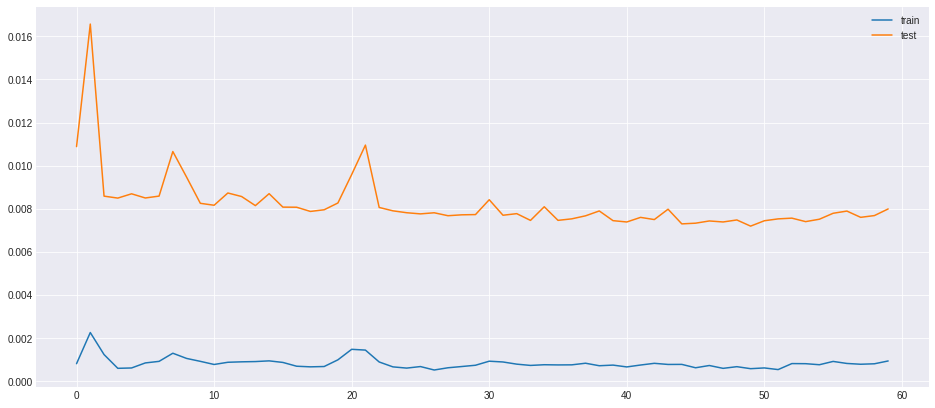

In [29]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [30]:
 #Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)

from tensorflow.keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)

predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(-1, 1))

test_actual = scaler_test.inverse_transform(testY.reshape(-1, 1))

2/2 [==============================] - 0s 8ms/step


In [31]:
predicted_btc_price_test_data

array([[51160.35 ],
       [51930.336],
       [51599.85 ],
       [49590.426],
       [47703.773],
       [46228.34 ],
       [45810.027],
       [46025.375],
       [45673.875],
       [46007.58 ],
       [47006.17 ],
       [48146.98 ],
       [48551.8  ],
       [48810.266],
       [48836.844],
       [47482.6  ],
       [45749.59 ],
       [44253.383],
       [43502.49 ],
       [43289.047],
       [43391.574],
       [43239.28 ],
       [43211.605],
       [43113.1  ],
       [42826.586],
       [42779.082],
       [43887.875],
       [45962.375],
       [47724.258],
       [48877.715],
       [49911.234],
       [51746.824],
       [53474.12 ],
       [54565.156],
       [55198.65 ],
       [55533.062],
       [56400.145],
       [56835.258],
       [56675.56 ],
       [57162.836],
       [58890.555],
       [59987.035],
       [60250.63 ],
       [60982.79 ],
       [62142.867],
       [63548.027],
       [63726.188],
       [62959.746],
       [62197.32 ],
       [62004.387],


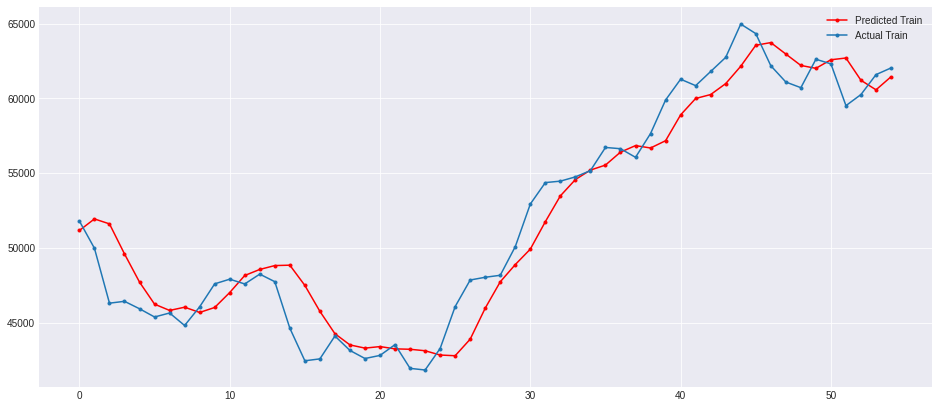

In [32]:
plt.figure(figsize=(16,7))

plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Train')

plt.plot(test_actual, marker='.', label='Actual Train')

plt.legend()
plt.show()

In [33]:
rmse_lstm_test = math.sqrt(mean_squared_error(test_actual, predicted_btc_price_test_data))

print('Test RMSE: %.3f' % rmse_lstm_test)

# With 2 Layers + Dropout + lookback=5 => I got - Test RMSE: 1666.162  => This seems best

Test RMSE: 1962.812
